# Using Shapash with Lime explainer - Titanic

You can compute your local contributions with the [Lime](https://github.com/marcotcr/lime) library and summarize them with Shapash

Contents:
- Build a Binary Classifier (Random Forest)
- Create Explainer using Lime
- Compile Shapash SmartExplainer
- Display local_plot
- to_pandas export

Data from Kaggle [Titanic](https://www.kaggle.com/c/titanic)

In [1]:
import numpy as np
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lime.lime_tabular

In [2]:
from shapash.data.data_loader import data_loading

In [3]:
titan_df, titan_dict = data_loading('titanic')
del titan_df['Name']

In [4]:
titan_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,Third class,male,22.0,1,0,7.25,Southampton,Mr
2,1,First class,female,38.0,1,0,71.28,Cherbourg,Mrs
3,1,Third class,female,26.0,0,0,7.92,Southampton,Miss
4,1,First class,female,35.0,1,0,53.10,Southampton,Mrs
5,0,Third class,male,35.0,0,0,8.05,Southampton,Mr


## Create Classification Model

In [5]:
y = titan_df['Survived']
X = titan_df.drop('Survived', axis=1)

In [6]:
varcat=['Pclass','Sex','Embarked','Title']

In [7]:
categ_encoding = OrdinalEncoder(cols=varcat, \
                                handle_unknown='ignore', \
                                return_df=True).fit(X)
X = categ_encoding.transform(X)

Train Test split + Random Forest fit

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.75, random_state=1)

rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=3)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Create Lime Explainer

In [9]:
#Training Tabular Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain.values, 
                                                   mode='classification',
                                                   feature_names=Xtrain.columns,
                                                   class_names=ytrain)

## Apply Explainer to Test Sample And Preprocessing

In [10]:
# Function features_check Extract feature names from Lime Output to be used by shapash
def features_check(s):
    for w in list(Xtest.columns):
        if f' {w} ' in f' {s} ' :
            feat = w
    return feat

In [11]:
%%time
# Compute local Lime Explanation for each row in Test Sample
contrib_l=[]
for ind in Xtest.index:
    exp = explainer.explain_instance(Xtest.loc[ind].values, rf.predict_proba, num_features=Xtest.shape[1])
    contrib_l.append(dict([[features_check(elem[0]),elem[1]] for elem in exp.as_list()]))

CPU times: user 57.8 s, sys: 7.34 s, total: 1min 5s
Wall time: 10.9 s


In [12]:
contribution_df =pd.DataFrame(contrib_l,index=Xtest.index)
# sorting the columns as in the original dataset
contribution_df = contribution_df[list(Xtest.columns)]

In [13]:
ypred=pd.DataFrame(rf.predict(Xtest),columns=['pred'],index=Xtest.index)

## Use Shapash With Lime Contributions

In [14]:
from shapash import SmartExplainer

In [15]:
xpl = SmartExplainer(
    model=rf,
    preprocessing=categ_encoding,
    features_dict=titan_dict
)

### Use contributions parameter of compile method to declare Lime contributions

In [16]:
xpl.compile(
    contributions=contribution_df, # Lime Contribution pd.DataFrame
    y_pred=ypred,
    y_target=ytest, # Optional: allows to display True Values vs Predicted Values
    x=Xtest
)

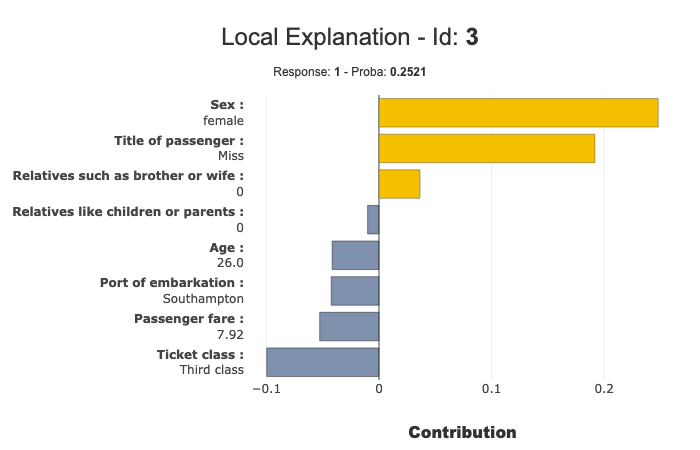

In [17]:
xpl.plot.local_plot(index=3)

In [18]:
summary_df = xpl.to_pandas(max_contrib=3,positive=True,proba=True)
summary_df.head()

,pred,proba,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
863,1,0.801675,Sex,female,0.257817,Title of passenger,Mrs,0.188714,Ticket class,First class,0.0880992
224,0,0.965208,Sex,male,0.248462,Title of passenger,Mr,0.199544,Ticket class,Third class,0.0838383
85,1,0.799397,Sex,female,0.25465,Title of passenger,Miss,0.193198,Age,17,0.0981314
681,1,0.786956,Sex,female,0.252464,Title of passenger,Miss,0.187045,Relatives such as brother or wife,0,0.0522808
536,1,0.936170,Sex,female,0.250703,Title of passenger,Miss,0.193096,Age,7,0.104632
